# Graph net for node classification

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [12]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import Adam
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import GraphClassificationLoss
from reco.datasetPU import TracksterGraph

import torch_geometric.nn as gnn


ds_name = "CloseByPion200PU"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [13]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [14]:
def knn_transform(data):
    # pos coordinates are on position 3:6
    data.edge_index = knn_graph(data.pos, k=4, loop=False)
    return data

def prepend_pos(data):
    # GravNet: add S to the front
    data.x = torch.hstack((data.pos, data.x))
    return data

transforms = T.Compose([prepend_pos])

In [15]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=200,
    pileup=True,
    radius=15,
    bigT_e_th=10,
)

In [16]:
ds

TracksterGraphPU(graphs=8125, nodes=239935, radius=15, bigT_e_th=10)

In [17]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True, drop_last=True)

Train graphs: 7313, Test graphs: 812, total: 8125


In [18]:
class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=2, dropout=0.2):
        super(TracksterGraphNet, self).__init__()

        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 64
        hdim2 = 64
        hdim3 = 64

        hdim_fc = 256

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2)
        self.edgeconv3 = DynamicEdgeConvBlock(hdim2, hdim3)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(hdim3, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
            nn.Softmax(dim=1),
        )

    def forward(self, X, batch=None):
        H0 = self.norm(X, batch)
        H1 = self.edgeconv1(H0, batch)
        H2 = self.edgeconv2(H1, batch)
        H3 = self.edgeconv3(H2, batch)
        return self.nodenetwork(H3)

In [19]:
def train_graph_classification(model, device, optimizer, loss_func, train_dl):
    train_loss = 0.
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x, data.batch)
        loss = loss_func(seg_pred, data)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

    return train_loss

In [20]:
@torch.no_grad()
def test_graph_classification(model, device, loss_func, test_dl):
    test_loss = 0.
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x, data.batch)
        loss = loss_func(seg_pred, data)
        test_loss += loss.item()

    return test_loss

In [21]:
model = TracksterGraphNet(input_dim=ds.data.x.shape[1])
epochs = 101
model_path = f"models/TracksterGraphNet.3b.DGCNN.ns.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [22]:
# %%script echo skipping
# alpha - percentage of negative edges
loss_func = GraphClassificationLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_graph_classification(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 5 == 0:
        test_loss = test_graph_classification(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 0.824	 validation loss: 0.575
Epoch 5:	 train loss: 0.548	 validation loss: 0.717
Epoch 10:	 train loss: 0.499	 validation loss: 0.496
Epoch 15:	 train loss: 0.473	 validation loss: 0.505
Epoch 20:	 train loss: 0.454	 validation loss: 0.472
Epoch 25:	 train loss: 0.439	 validation loss: 0.574
Epoch 30:	 train loss: 0.420	 validation loss: 0.469
Epoch 35:	 train loss: 0.403	 validation loss: 0.461
Epoch 40:	 train loss: 0.393	 validation loss: 0.483
Epoch 45:	 train loss: 0.378	 validation loss: 0.477
Epoch 50:	 train loss: 0.364	 validation loss: 0.488
Epoch 55:	 train loss: 0.353	 validation loss: 0.505
Epoch 60:	 train loss: 0.341	 validation loss: 0.452
Epoch 65:	 train loss: 0.333	 validation loss: 0.461
Epoch 70:	 train loss: 0.320	 validation loss: 0.472
Epoch 75:	 train loss: 0.316	 validation loss: 0.471
Epoch 80:	 train loss: 0.307	 validation loss: 0.466
Epoch 85:	 train loss: 0.303	 validation loss: 0.465
Epoch 90:	 train loss: 0.298	 validation loss: 0

models/TracksterGraphNet.3b.DGCNN.ns.101e-CloseByPion200PU.r15.e10.f200.pt


Epoch 100:	 train loss: 0.295	 validation loss: 0.458


In [23]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


0.9410394946050228


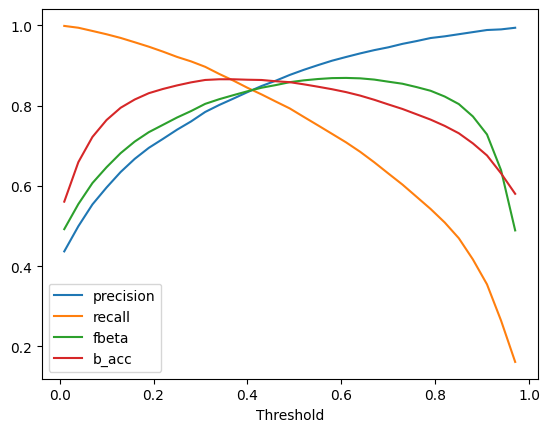

TP: 6711, TN: 13407, FP: 573, FN: 2761
TH: 0.61 precision: 0.921 recall: 0.709 fbeta: 0.869 b_acc: 0.834


In [25]:
#%%script echo skipping - only evaluating foreground
print(roc_auc(model, device, test_dl))
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3, truth_threshold=0.5)

## Scoreboard
- 2 layers, 200 files, 0.944

## Eval

Overfit on the training set - need more data!

In [26]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation
from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15643817_2.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name, pileup=True)

In [27]:
r_ranges = [3, 5, 10, 15]
results = []

max_events = 20
clue3D_F = []
target_F = []
naive_reco_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(output_dim=2),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=5,
        pileup=True,
        graph=True,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    naive_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.6,
        radius=r,
        max_events=max_events,
        bigT_e_th=5,
        pileup=True,
        graph=True,
    )
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 3 ---
Event 0:
	clue3d_to_sim:	P: 0.802 R: 0.307 F: 0.607
	target_to_sim:	P: 0.797 R: 0.354 F: 0.638
	reco_to_sim:	P: 0.789 R: 0.354 F: 0.634
	|S| = 1 |T| = 5 |R| = 5
Event 1:
	clue3d_to_sim:	P: 0.993 R: 0.335 F: 0.713
	target_to_sim:	P: 0.993 R: 0.335 F: 0.713
	reco_to_sim:	P: 0.993 R: 0.335 F: 0.713
	|S| = 1 |T| = 3 |R| = 3
Event 2:
	clue3d_to_sim:	P: 0.955 R: 0.221 F: 0.573
	target_to_sim:	P: 0.956 R: 0.264 F: 0.627
	reco_to_sim:	P: 0.928 R: 0.264 F: 0.618
	|S| = 1 |T| = 3 |R| = 3
Event 3:
	clue3d_to_sim:	P: 0.976 R: 0.793 F: 0.933
	target_to_sim:	P: 0.976 R: 0.793 F: 0.933
	reco_to_sim:	P: 0.976 R: 0.793 F: 0.933
	|S| = 1 |T| = 2 |R| = 2
Event 4:
	clue3d_to_sim:	P: 0.727 R: 0.595 F: 0.696
	target_to_sim:	P: 0.727 R: 0.595 F: 0.696
	reco_to_sim:	P: 0.727 R: 0.595 F: 0.696
	|S| = 1 |T| = 1 |R| = 1
Event 5:
	clue3d_to_sim:	P: 1.000 R: 0.511 F: 0.839
	target_to_sim:	P: 1.000 R: 0.511 F: 0.839
	reco_to_sim:	P: 1.000 R: 0.511 F: 0.839
	|S| = 1 |T| = 1 |R| = 1
Event

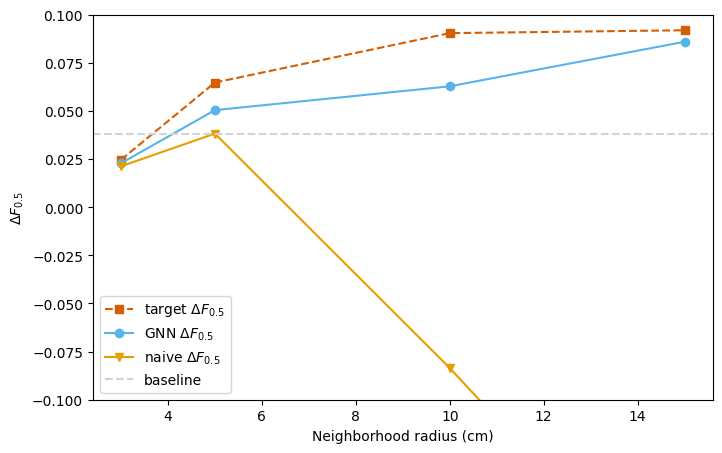

In [30]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="GNN $\Delta F_{0.5}$", c="#56B4E9")
ax.plot(r_ranges[:6], (np.array(naive_reco_F) - np.array(clue3D_F))[:6], '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")
ax.set_ylim((-0.1, 0.1))

fig.savefig(f'export/{ds_name}-e5-graph-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [31]:
print("Reco", max(np.array(model_reco_F) - np.array(clue3D_F)))
print("Naive", max(np.array(naive_reco_F) - np.array(clue3D_F)))
print("Target", max(np.array(target_F) - np.array(clue3D_F)))

Reco 0.08595171265228418
Naive 0.038259243432028134
Target 0.09192953931184766


## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796